In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import urllib.request
import os
import jax
from jax import lax, tree, grad, jit, vmap, value_and_grad, hessian
import jax.scipy.stats as jstats
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
from diffrax import diffeqsolve,Tsit5, ODETerm, SaveAt, RecursiveCheckpointAdjoint, DirectAdjoint, Event
import pandas as pd
from functools import partial

jax.config.update("jax_enable_x64", True)
colors = sns.color_palette()
key = jr.PRNGKey(0)

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Example – The catalysis problem using variational inference

Let's do variational inference for the catalysis problem.

## Model for data generation

The model was described in detail in the activity where we introduced the classical approach to inverse problems.
We'll briefly summarize it here.

### Catalysis dynamics

Recall that we have modeled the production of various chemicals in a catalytic reaction with the following ODE:

$$
\begin{aligned}
\dot{z} &= A(k)z \\
z(0) &= (500,0,0,0,0,0) \in \mathbb{R}^6
\end{aligned}
$$

where $z \in \mathbb{R}^6$ are the concentrations of each chemical.
The linear dynamics $A$ depend on some (unknown) kinetic rates $k \in \mathbb{R}_+^5$ as

$$
A(k) = \left(\begin{array}{cccccc}
-k_1 & 0 & 0 & 0 & 0 & 0\\
k_1 & -(k_2+k_4+k_5) & 0 & 0 & 0 & 0\\
0 & k_2 & -k_3 & 0 & 0 & 0\\
0 & 0 & k_3 & 0 & 0 & 0\\
0 & k_4 & 0 & 0 & 0 & 0\\
0 & k_5 & 0 & 0 & 0 & 0
\end{array}\right)\in\mathbb{R}^{6\times 6}.
$$

### Inverse problem setup

We want to infer the rates, $k$, from data.
For numerical stability, let's work with the scaled quantities $\tilde{z} = \frac{z}{500}, \tilde t = \frac{t}{180}$, and $\tilde k = \frac{180k}{500}$ so that our ODE becomes

$$
\begin{aligned}
\dot{\tilde z} &= A(\tilde k) \tilde z \\
\tilde z(0) &= (1,0,0,0,0,0) \in \mathbb{R}^6,
\end{aligned}
$$

We'll denote the solution of the scaled ODE at time $t$ as $\tilde z(t; \tilde k)$.
The full probabilistic model is

$$
\begin{aligned}
    \log \tilde k &\sim \mathcal{N}(0, \gamma^2 I) &\quad \text{Lognormal prior on rates} \\
    \tilde \sigma^2 &\sim \text{Exp}(\lambda) &\quad \text{Exponential prior on noise variance} \\
    Y_{ij} 
    &\sim \mathcal{N}\Big(\tilde z\big(\mathbf{\tilde t}, \tilde k\big), \tilde \sigma^2\Big) &\quad \text{Independent Gaussian measurements}
\end{aligned}
$$

where $\gamma=2$, $\lambda=\frac{1}{0.1}$, and $Y \in \mathbb{R}^{5 \times 6}$ are the observed concentrations for 5 of the chemicals at 6 equally-spaces times $\mathbf{\tilde t} = \left( \frac{1}{6}, \frac{1}{3}, \frac{1}{2}, \frac{2}{3}, \frac{5}{6}, 1 \right)$.

Finally, let's follow the common practice of mapping all random variables to a standard Gaussian random vector $x \in \mathbb{R}^6$.
To this end, let $T$ be the transformation such that

$$
T(x) = (k, ~ \sigma^2)
$$

and 

$$
x \sim \mathcal{N}(0, I).
$$

Our goal is now to use variational inference to characterize the posterior 

$$
p(x|Y) \propto \underbrace{p(Y|x) p(x)}_{\substack{\text{generative model} \\ \text{for the} \\ \text{catalysis dataset}}}.
$$

Let's import the data and define the solver:

In [2]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/data/catalysis.csv'
download(url)
catalysis_data = pd.read_csv('catalysis.csv')
catalysis_data = catalysis_data[catalysis_data['Time'] > 0.0].reset_index(drop=True)
t_obs = jnp.array(catalysis_data['Time'].values, dtype=float)
Y_obs = jnp.array(catalysis_data[['NO3', 'NO2', 'N2', 'NH3', 'N2O']].values.T, dtype=float)
t_scale = 180.0
z_scale = 500.0

t_obs_scaled = t_obs / t_scale
Y_obs_scaled = Y_obs / z_scale

k_transformation = lambda x: jnp.exp(x) / t_scale

z0_scaled = jnp.array([500.0, 0.0, 0.0, 0.0, 0.0, 0.0])/z_scale
model_kwargs = dict(
    z0=z0_scaled,
    y=Y_obs_scaled,
    t=t_obs_scaled,
    gamma=2.0,
    lambda_=1/0.005,
)

# Define the linear system
def A(k):
    """
    Return the matrix of the dynamical system.
    """
    # jax.debug.print('k = {k}', k=k)
    res = jnp.zeros((6, 6))
    res = res.at[0, 0].set(-k[0])
    res = res.at[1, 0].set(k[0])
    res = res.at[1, 1].set(-(k[1] + k[3] + k[4]))
    res = res.at[2, 1].set(k[1])
    res = res.at[2, 2].set(-k[2])
    res = res.at[3, 2].set(k[2])
    res = res.at[4, 1].set(k[4])
    res = res.at[5, 1].set(k[3])
    return res

def dynamic_sys(t, z, k):
    return jnp.dot(A(k), z)

def state_has_nan(t, y, args, **kwargs):
    return jnp.isnan(y).any()

# Solve the ODE using Diffrax
def solve_catalysis(t, k, z0, make_compatible_with_hessian):

    if make_compatible_with_hessian:
        solver = Tsit5(scan_kind="bounded")
        adjoint = DirectAdjoint()
    else:
        solver = Tsit5()
        adjoint = RecursiveCheckpointAdjoint()
        
    sol = diffeqsolve(
        ODETerm(dynamic_sys),
        solver=solver,
        t0=0.0,
        t1=t[-1],
        dt0=0.001,
        y0=z0,
        args=k,
        saveat=SaveAt(ts=t),
        adjoint=adjoint,
        throw=True,
        event=Event(state_has_nan)  # Here, we are telling the solver to stop once a NaN is detected.
    )
    return sol.ys

As a reminder, here is what the data look like:

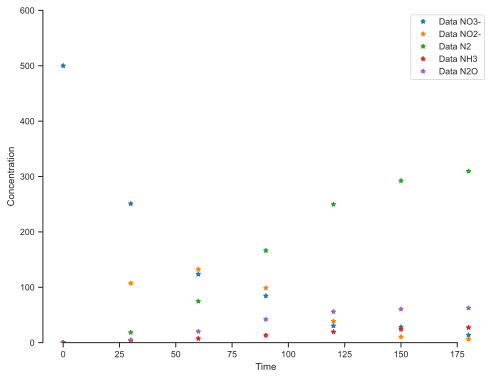

In [19]:
# Plotting with noise
fig, ax = plt.subplots(figsize=(8, 6))

# Define labels and colors
labels = ['NO3-', 'NO2-', 'N2', 'NH3', 'N2O', 'X']
data_cols = ['NO3', 'NO2', 'N2', 'NH3', 'N2O']
model_cols = [0, 1, 3, 4, 5, 2]

# Plot experimental data
for i, col in enumerate(data_cols):
    ci = 500.0 if data_cols[i] == 'NO3' else 0.0
    ax.plot(jnp.hstack([0.0, t_obs]), jnp.hstack([ci, jnp.array(catalysis_data[col])]), '*', color=colors[i], label=f'Data {labels[i]}')

ax.set_ylim(0, 600)
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
plt.legend()
sns.despine(trim=True)
plt.show()

And here is the negative log unnormalized posterior, i.e., $-\log p(x|Y) = -\log p(Y|x) - \log p(x)$:

In [3]:
def T(x, gamma, lambda_):
    """Transforms a standard normal random vector into the parameters of the model."""
    # Get reaction rates
    k = jnp.exp(x[:-1]*gamma)

    # Get measurement noise variance
    expon_icdf = lambda p: -jnp.log1p(-p)  # Inverse CDF of Exp(1)
    norm_to_expon = lambda x: expon_icdf(jstats.norm.cdf(x))  # This converts a N(0,1) to Exp(1)
    sigma2 = norm_to_expon(x[-1])/lambda_

    return k, sigma2

# Negative log posterior
def minus_log_post(x, z0, y, t, gamma, lambda_, make_compatible_with_hessian=False, solve_catalysis=solve_catalysis):
    """Negative log posterior of the catalysis model."""
    
    # Negative log prior
    prior = 0.5*jnp.sum(x**2)

    # Get reaction rates and measurement noise variance
    k, sigma2 = T(x, gamma, lambda_)

    # Simulate physical process
    states = solve_catalysis(t, k, z0, make_compatible_with_hessian)
    obs_states = jnp.hstack([states[:, :2], states[:, 3:]])  # We don't observe the third component

    # Negative log likelihood
    likelihood = 0.5*jnp.sum((obs_states.T - y)**2) / sigma2

    # Total negative log posterior
    posterior = likelihood + prior
    
    return posterior

### Warning: Guarding against "bad" parameter values

Since **Bayesian inference algorithms** (such as variational inference) try to characterize an entire probability distribution, they **will often visit regions of parameter space that have *extremely* low posterior probability density**.
Unfortunately, parameter values in these "bad" regions also tend to cause numerical issues for any ODE solvers in the likelihood.

To guard against this, we'd ideally choose a prior on the parameters that excludes these "bad" regions.
In practice, however, it is usually not obvious what this prior should be.
**In variational inference, a more practical approach is to simply catch these "bad" parameter values early and skip the ODE solve**.
Since these "bad" parameter values were unlikely to begin with, skipping them will not affect the final posterior approximation.

We have already implemented this in the code above by passing in `event=Event(state_has_nan)` into the ODE solver.
This tells the solver to **exit prematurely if it detects a NaN value in the solution**.

## Multivariate normal guide

<!-- The guide $q_\phi(x)$ is a probability distribution that is parameterized by *variational parameters* $\phi \in \mathbb{R}^v$. -->
Let's choose the guide to be a multivariate normal distribution, i.e.,

$$
q_\phi(x) = \mathcal{N}(\mu_\phi, \Sigma_\phi).
$$

where $\phi \in \mathbb{R}^v$ are the *variational parameters*.
The mean, $\mu$, of the guide is parameterized as

$$
\mu_\phi = ( \phi_1 \ldots \phi_6 ) \in \mathbb{R}_+^5
$$

<!-- $$
\mu_\phi = \begin{pmatrix}\exp (\phi_1) & \ldots & \exp (\phi_6) \end{pmatrix} \in \mathbb{R}_+^5
$$ -->

<!-- $$
\mu_\phi = \begin{pmatrix}\exp (w_1 \phi_1 + b_1) & \ldots & \exp (w_6 \phi_6 + b_6) \end{pmatrix} \in \mathbb{R}_+^5
$$ -->

<!-- $$
\mu_\phi \equiv \begin{pmatrix} \mu_1 \dots \mu_6 \end{pmatrix} = \begin{pmatrix}\exp \big\{s_1(\phi_1)\big\} & \ldots & \exp \big\{s_6(\phi_6)\big\} \end{pmatrix} \in \mathbb{R}_+^6.
$$ -->

We'll represent the covariance matrix, $\Sigma_\phi$, with its Cholesky decomposition

<!-- $$
\Sigma_\phi = L_\phi L_\phi^T \quad \text{with} \quad L_\phi = \begin{pmatrix} \exp(\phi_6) & 0 & 0 & 0 & 0 \\ \phi_{11} & \exp(\phi_7) & 0 & 0 & 0 \\ \phi_{12} & \phi_{13} & \exp(\phi_8) & 0 & 0 \\ \phi_{14} & \phi_{15} & \phi_{16} & \exp(\phi_9) & 0 \\ \phi_{17} & \phi_{18} & \phi_{19} & \phi_{20} & \exp(\phi_{10}) \end{pmatrix} \in R^{5 \times 5}
$$ -->

<!-- $$
\Sigma_\phi = L_\phi L_\phi^T \quad \text{with} \quad L_\phi = \begin{pmatrix} \exp(\phi_7) & 0 & 0 & 0 & 0 & 0 \\ \phi_{13} & \exp(\phi_8) & 0 & 0 & 0 & 0 \\ \phi_{14} & \phi_{15} & \exp(\phi_9) & 0 & 0 & 0 \\ \phi_{16} & \phi_{17} & \phi_{18} & \exp(\phi_{10}) & 0 & 0 \\ \phi_{19} & \phi_{20} & \phi_{21} & \phi_{22} & \exp(\phi_{11}) & 0 \\ \phi_{23} & \phi_{24} & \phi_{25} & \phi_{26} & \phi_{27} & \exp(\phi_{12}) \end{pmatrix} \in R^{6 \times 6}
$$ -->

<!-- $$
\Sigma_\phi = L_\phi L_\phi^T \quad \text{with} \quad L_\phi = \begin{pmatrix} \exp(s_7 \phi_7) & 0 & 0 & 0 & 0 & 0 \\ s_{13} \phi_{13} & \exp(s_8 \phi_8) & 0 & 0 & 0 & 0 \\ s_{14} \phi_{14} & s_{15} \phi_{15} & \exp(s_9 \phi_9) & 0 & 0 & 0 \\ s_{16} \phi_{16} & s_{17} \phi_{17} & s_{18} \phi_{18} & \exp(s_{10} \phi_{10}) & 0 & 0 \\ s_{19} \phi_{19} & s_{20} \phi_{20} & s_{21} \phi_{21} & s_{22} \phi_{22} & \exp(s_{11} \phi_{11}) & 0 \\ s_{23} \phi_{23} & s_{24} \phi_{24} & s_{25} \phi_{25} & s_{26} \phi_{26} & s_{27} \phi_{27} & \exp(s_{12} \phi_{12}) \end{pmatrix} \in R^{6 \times 6}
$$ -->

<!-- $$
\Sigma_\phi = L_\phi L_\phi^T \quad \text{with} \quad L_\phi = \begin{pmatrix} \exp(w_7 \phi_7 + b_7) & 0 & 0 & 0 & 0 & 0 \\ w_{13} \phi_{13} + b_{13} & \exp(w_8 \phi_8 + b_8) & 0 & 0 & 0 & 0 \\ w_{14} \phi_{14} + b_{14} & w_{15} \phi_{15} + b_{15} & \exp(w_9 \phi_9 + b_9) & 0 & 0 & 0 \\ w_{16} \phi_{16} + b_{16} & w_{17} \phi_{17} + b_{17} & w_{18} \phi_{18} + b_{18} & \exp(w_{10} \phi_{10} + b_{10}) & 0 & 0 \\ w_{19} \phi_{19} + b_{19} & w_{20} \phi_{20} + b_{20} & w_{21} \phi_{21} + b_{21} & w_{22} \phi_{22} + b_{22} & \exp(w_{11} \phi_{11} + b_{11}) & 0 \\ w_{23} \phi_{23} + b_{23} & w_{24} \phi_{24} + b_{24} & w_{25} \phi_{25} + b_{25} & w_{26} \phi_{26} + b_{26} & w_{27} \phi_{27} + b_{27} & \exp(w_{12} \phi_{12} + b_{12}) \end{pmatrix} \in R^{6 \times 6}
$$ -->

$$
\Sigma_\phi = L_\phi L_\phi^T
$$ 

and we'll parameterize the Cholesky factor $L_\phi$ as

$$
L_\phi = \begin{pmatrix} \exp(\phi_6) & 0 & 0 & 0 & 0 \\ \phi_{11} & \exp(\phi_7) & 0 & 0 & 0 \\ \phi_{12} & \phi_{13} & \exp(\phi_8) & 0 & 0 \\ \phi_{14} & \phi_{15} & \phi_{16} & \exp(\phi_9) & 0 \\ \phi_{17} & \phi_{18} & \phi_{19} & \phi_{20} & \exp(\phi_{10}) \end{pmatrix} \in R^{5 \times 5}.
$$

Parameterizing this way ensures the covariance matrix is positive definite.
We now have a parameterized guide $q_\phi$, where $\phi$ fully specifies a multivariate normal distribution.
Here it is:

<!-- $$
L_\phi = \begin{pmatrix} \exp\big\{s_7(\phi_7)\big\} & 0 & 0 & 0 & 0 & 0 \\ s_{13}(\phi_{13}) & \exp\big\{s_8(\phi_8)\big\} & 0 & 0 & 0 & 0 \\ s_{14}(\phi_{14}) & s_{15}(\phi_{15}) & \exp\big\{s_9(\phi_9)\big\} & 0 & 0 & 0 \\ s_{16}(\phi_{16}) & s_{17}(\phi_{17}) & s_{18}(\phi_{18}) & \exp\big\{s_{10}(\phi_{10})\big\} & 0 & 0 \\ s_{19}(\phi_{19}) & s_{20}(\phi_{20}) & s_{21}(\phi_{21}) & s_{22}(\phi_{22}) & \exp\big\{s_{11}(\phi_{11})\big\} & 0 \\ s_{23}(\phi_{23}) & s_{24}(\phi_{24}) & s_{25}(\phi_{25}) & s_{26}(\phi_{26}) & s_{27}(\phi_{27}) & \exp\big\{s_{12}(\phi_{12})\big\} \end{pmatrix} \in R^{6 \times 6}.
$$ -->

<!-- Here, the functions $s_i(\phi_i) \equiv a_i + b_i \phi_i$ scale the variational parameters, where $a,b \in \mathbb{R}^v$ are fixed. -->

<!-- Note, we've chosen the parameterization so that (1) the means are all positive, (2) the covariance matrix is positive definite, and (3) the guide is scaled appropriately. -->

In [4]:
class MultivariateNormalGuide(eqx.Module):
    """Class that represents a multivariate normal guide with variational parameters phi."""
    phi: jnp.ndarray
    num_x: int = eqx.field(static=True, default=None)

    def __post_init__(self):
        if self.phi.shape[0] != self._get_phi_required_size(self.num_x):
            raise ValueError("The length of phi is not consistent with the number of parameters.")
        
    def logprob(self, x):
        """The log probability density of the guide."""
        return jax.scipy.stats.multivariate_normal.logpdf(x, self.mu, self.Sigma)
    
    def sample(self, key, num_samples):
        """Samples from the guide."""
        return jr.multivariate_normal(key, self.mu, self.Sigma, shape=(num_samples,))
    
    def forward(self, xi):
        """Transforms a multivariate normal sample to a sample from the guide, as per the reparameterization trick."""
        return self.mu + jnp.dot(self.L, xi)

    @property
    def mu(self):
        """The mean of the guide."""
        return self.phi[:self.num_x]

    @property
    def Sigma(self):
        """The covariance of the guide."""
        L = self.L
        return jnp.dot(L, L.T)
    
    @property
    def L(self):
        """The Cholesky decomposition of the covariance of the guide."""
        # The diagonal
        ell = jnp.exp(self.phi[self.num_x:2*self.num_x])
        L = jnp.diag(ell)

        # The lower triangular part
        L = L.at[jnp.tril_indices(self.num_x, -1)].set(self.phi[2*self.num_x:])
        return L

    @classmethod
    def from_mean_covariance(cls, mu, Sigma):
        """Constructs a guide with a given mean and covariance. Useful for initializing phi to a reasonable value."""
        L = jnp.linalg.cholesky(Sigma)
        ell = jnp.diag(L)
        tri = L[jnp.tril_indices(L.shape[0], -1)]
        phi = jnp.hstack([mu, jnp.log(ell), tri])
        return cls(phi, mu.shape[0])
    
    @staticmethod
    def _get_phi_required_size(num_x):
        return num_x + num_x*(num_x + 1)//2

# Test
_q_test = MultivariateNormalGuide(phi=jnp.arange(27, dtype=float), num_x=6)
assert jnp.all(jnp.isclose(_q_test.phi, MultivariateNormalGuide.from_mean_covariance(_q_test.mu, _q_test.Sigma).phi))

Here is how we can initialize the guide to match the prior distribution:

In [5]:
# Set the guide to a standard Gaussian
q_init = MultivariateNormalGuide.from_mean_covariance(mu=jnp.zeros(6), Sigma=jnp.eye(6))

Let's plot some concentration-vs-time trajectories, sampled from the prior:

In [6]:
def plot_guide_samples(q, num_samples, key):
    times_scaled = jnp.linspace(0.0, t_obs_scaled[-1], 1000)
    x_samples = jax.random.multivariate_normal(key, q.mu, q.Sigma, shape=(num_samples,))
    k_samples = vmap(partial(T, gamma=model_kwargs['gamma'], lambda_=model_kwargs['lambda_']))(x_samples)[0]

    # Compute the samples with noise
    z_samples_scaled = jnp.array([solve_catalysis(times_scaled, k, model_kwargs['z0'], False) for k in k_samples])

    times = times_scaled*t_scale
    z_samples = z_samples_scaled*z_scale

    # Compute the median model with noise
    median_models_noise = jnp.median(z_samples, axis=0)

    # Plotting with noise
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define labels and colors
    labels = ['NO3-', 'NO2-', 'N2', 'NH3', 'N2O', 'X']
    data_cols = ['NO3', 'NO2', 'N2', 'NH3', 'N2O']
    model_cols = [0, 1, 3, 4, 5, 2]

    # Plot experimental data
    for i, col in enumerate(data_cols):
        ax.plot(t_obs, catalysis_data[col], '*', color=colors[i], label=f'Data {labels[i]}')

    # Plot the mean models with noise
    for i, col in enumerate(model_cols):
        ax.plot(times, median_models_noise[:, col], color=colors[i], label=f'Model {labels[i]}')

    for i in range(num_samples):
        for j, col in enumerate(model_cols):
            ax.plot(times, z_samples[i, :, col], color=colors[j], alpha=0.2)
    ax.set_ylim(0, 600)
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    plt.legend()
    sns.despine(trim=True)
    plt.show()

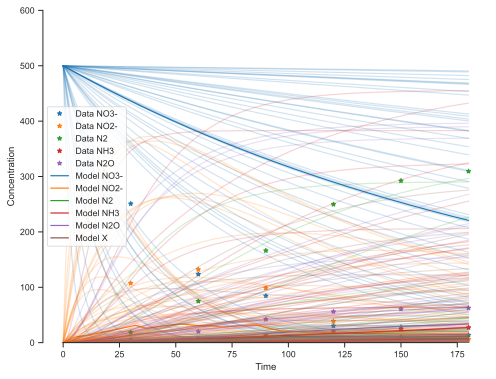

In [7]:
key, subkey = jr.split(key)
plot_guide_samples(q=q_init, num_samples=50, key=subkey)

The prior seems reasonable.
If we didn't have the data, any of these trajectories could be plausible.

## Maximizing the ELBO
The goal of variational inference is to find optimal parameters $\phi$ so that the guide is as close as possible to the true posterior $p(x|Y).$
We do this by maximizing the Evidence Lower Bound (ELBO):

$$
\text{ELBO}(\phi) = \mathbb{E}_{x \sim q_\phi}\underbrace{\left[\log p(Y|x) + \log p(x) - \log q_\phi(x)\right]}_{\equiv f(x)} = \mathbb{E}_{x \sim q_\phi}\left[f(x)\right]
$$

We'll use a stochastic optimization algorithm (e.g., Adam) to maximize the ELBO. 
This requires estimating the gradient of the ELBO with respect to the variational parameters $\phi$, i.e., $\nabla_\phi \text{ELBO}(\phi)$.
Using the reparameterization trick, we remove the expectation operator's dependence on $\phi$ so that

$$
\nabla_\phi \text{ELBO}(\phi) 
= \nabla_\phi \mathbb{E}_{x \sim q_\phi}\left[ f(x)\right]
= \nabla_\phi \mathbb{E}_{\xi \sim \mathcal{N}(0, I)}\bigg[ f\Big(g_\phi(\xi)\Big)\bigg]
= \mathbb{E}_{\xi \sim \mathcal{N}(0, I)}\bigg[ \nabla_\phi f\Big(g_\phi(\xi)\Big)\bigg]
$$

where $g_\phi(\xi) = \mu_\phi + L_\phi \xi$ transforms a sample from $\mathcal{N}(0,I)$ to one from $q_\phi$.
The ELBO gradient can now be estimated by Monte Carlo sampling:

$$
\widehat{\nabla_\phi \text{ELBO}}(\phi) = \frac{1}{N} \sum_{i=1}^N \nabla_\phi f\Big(g_\phi(\xi_i)\Big)
$$

where $\xi_i \sim \mathcal{N}(0, I)$ and $N$ is the batch size.

We will minimize the negative ELBO (equivalent to maximizing the ELBO):

In [8]:
def neg_elbo(phi, xi, model_kwargs, num_x):
    """The integrand of the negative reparameterized ELBO, f(g_phi(xi))."""
    q = MultivariateNormalGuide(phi=phi, num_x=num_x)
    x = q.forward(xi)
    return minus_log_post(x, **model_kwargs) + q.logprob(x)

We are now ready to do variational inference:

In [9]:
def step(carry, _, optim, batch_size, model_kwargs, num_x):
    """A single optimization step."""
    phi, opt_state, key = carry
    
    # Sample latent variable xi
    key, key_xi = jr.split(key)
    xi = jr.normal(key_xi, shape=(batch_size, num_x))

    # Compute ELBO gradient estimate
    neg_elbo_val, neg_elbo_grad = tree.map(
        lambda x: jnp.sum(x, axis=0), 
        vmap(value_and_grad(neg_elbo), in_axes=(None, 0, None, None))(phi, xi, model_kwargs, num_x)
    )

    # Update variational parameters phi
    updates, opt_state = optim.update(neg_elbo_grad, opt_state)
    phi = optax.apply_updates(phi, updates)

    return (phi, opt_state, key), neg_elbo_val

# Setup
optim = optax.apply_if_finite(optax.adam(5e-2), 10)
step_frozen_args = jit(partial(step, optim=optim, batch_size=5, model_kwargs=model_kwargs, num_x=6))
key, subkey = jr.split(key)
vi_state = (q_init.phi, optim.init(q_init.phi), subkey)
neg_elbo_vals = []
print_every = 100
num_iter = 3000

# Run variational inference loop
for i in range(num_iter):
    vi_state, neg_elbo_val = step_frozen_args(vi_state, None)
    neg_elbo_vals.append(neg_elbo_val)
    if (i + 1) % print_every == 0:
        print(f"Iteration {(i + 1):4d}/{num_iter:4d} \t ELBO: {jnp.mean(jnp.array(neg_elbo_vals[-print_every:])):.2f}")

# Extract optimized guide parameters and ELBO values
phi_opt, _, _ = vi_state
neg_elbo_vals = jnp.array(neg_elbo_vals)

Iteration  100/3000 	 ELBO: 427.27
Iteration  200/3000 	 ELBO: 39.87
Iteration  300/3000 	 ELBO: 34.05
Iteration  400/3000 	 ELBO: 32.47
Iteration  500/3000 	 ELBO: 31.74
Iteration  600/3000 	 ELBO: 31.15
Iteration  700/3000 	 ELBO: 30.76
Iteration  800/3000 	 ELBO: 30.81
Iteration  900/3000 	 ELBO: 30.64
Iteration 1000/3000 	 ELBO: 30.86
Iteration 1100/3000 	 ELBO: 30.64
Iteration 1200/3000 	 ELBO: 29.88
Iteration 1300/3000 	 ELBO: 31.05
Iteration 1400/3000 	 ELBO: 31.79
Iteration 1500/3000 	 ELBO: 31.27
Iteration 1600/3000 	 ELBO: 31.18
Iteration 1700/3000 	 ELBO: 30.29
Iteration 1800/3000 	 ELBO: 30.71
Iteration 1900/3000 	 ELBO: 31.42
Iteration 2000/3000 	 ELBO: 31.99
Iteration 2100/3000 	 ELBO: 31.31
Iteration 2200/3000 	 ELBO: 33.40
Iteration 2300/3000 	 ELBO: 30.80
Iteration 2400/3000 	 ELBO: 31.50
Iteration 2500/3000 	 ELBO: 33.25
Iteration 2600/3000 	 ELBO: 31.19
Iteration 2700/3000 	 ELBO: 30.68
Iteration 2800/3000 	 ELBO: 32.73
Iteration 2900/3000 	 ELBO: 31.79
Iteration 300

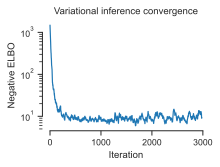

In [10]:
fig, ax = plt.subplots(figsize=(3, 2))
sliding_window = 20
elbo_vals_averaged = jnp.convolve(neg_elbo_vals - neg_elbo_vals.min(), jnp.ones(sliding_window)/sliding_window, mode='valid')
iters_averaged = jnp.arange(neg_elbo_vals.shape[0])[:elbo_vals_averaged.shape[0]]
ax.plot(iters_averaged, elbo_vals_averaged)
ax.set_title('Variational inference convergence')
ax.set_xlabel('Iteration')
ax.set_ylabel('Negative ELBO')
ax.set_yscale('log')
sns.despine(trim=True)

We now have a good approximation to the posterior, i.e., we've found $\phi$ such that $q_\phi(x) \approx p(x|Y)$.
Nice!

Let's plot concentration-vs-time trajectories, sampled from the *posterior*:

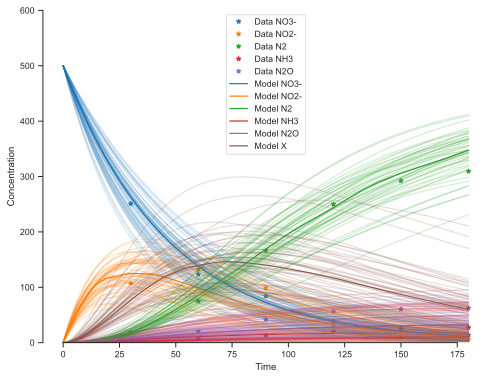

In [11]:
q = MultivariateNormalGuide(phi=phi_opt, num_x=6)
key, subkey = jr.split(key)
plot_guide_samples(q=q, num_samples=50, key=subkey)

It looks reasonable.
We can also visualize at the posterior correlation between the parameters with a heatmap:

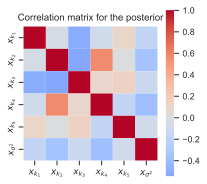

In [12]:
var_names = [r'{k_1}', r'{k_2}', r'{k_3}', r'{k_4}', r'{k_5}', r'{\sigma^2}']

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(jnp.corrcoef(q.Sigma), ax=ax, cmap='coolwarm', center=0)
ax.set_title('Correlation matrix for the posterior')
ax.set_aspect('equal')
ax.set_xticklabels([rf'$x_{i}$' for i in var_names])
ax.set_yticklabels([rf'$x_{i}$' for i in var_names]);

## Questions

- **Try playing with the prior.** 
  - Increase the prior mean measurement noise variance $\lambda$ to 0.1 (i.e., by setting `lambda_` to `1/0.1`). 
    How does this affect the posterior approximation? What about if you decrease $\lambda$?
  - Increase the prior log-rate parameter st. dev. $\gamma$ to 3 (i.e., by setting `gamma` to `3`).
    Does this change the posterior approximation? What about if you decrease $\gamma$?
- **Play with the starting point.** Start variational inference from different points by modifying `q_init`.
  Does the optimization algorithm always converge to the same solution?